In [1]:
# Import a whole load of useful packages
import numpy as np 
import pandas as pd
from netCDF4 import Dataset
import geopandas as gpd
import matplotlib.pyplot as plt
import rasterio
import os.path
import re
from osgeo import gdal
from osgeo import gdal_array
from osgeo import osr
import glob
import itertools
from matplotlib.pyplot import cm
from matplotlib.ticker import LogFormatter
import matplotlib.colors
from scipy.interpolate import griddata 
from scipy.fft import fft, ifft, fft2, ifft2, fftshift, fftfreq
from scipy import signal
from scipy.optimize import minimize
kw = dict(origin='lower', aspect='auto') # Some standards for imshow plots
import memory_profiler

In [3]:
# Create arrays of transfer functions (2008)
def Tsb(k,l, alpha_s):
    j2 = k ** 2 + l ** 2
    TSBtop = k * ( 1 + m * (1 + 2 * j2 * C))
    TSBbase = k + m * (k + (2 * k * j2 * C) + ((complex(0,1)) * j2 * (1/np.tan(alpha_s))))
    TSB = TSBtop/TSBbase
    return TSB    

def Tub(k,l, alpha_s):
    l2 = l**2
    k2 = k ** 2
    j2 = k ** 2 + l ** 2
    cot = (1/np.tan(alpha_s))
    TUBtop = complex(0,-1) * cot * ((m * l2) - (k2 * (1 + 0.5 * j2 * m * C)))
    TUBbase1 = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TUBbase2 = ((1/(m*C))+ 0.5 * j2) 
    TUBbase = TUBbase1 * TUBbase2
    TUB = TUBtop/TUBbase
    return TUB#
#
def Tvb(k,l, alpha_s):
    j2 = l ** 2 + k ** 2 
    cot = (1/np.tan(alpha_s))
    TVBtop = complex(0,1) * k * l * cot * (1 + m + (0.5 * j2 * C * m))
    TVBbase1 = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TVBbase2 = ((1/(m*C))+ 0.5 * j2) 
    TVBbase = TVBbase1 * TVBbase2
    TVB = TVBtop/TVBbase
    return TVB#

def Tsc(k,l, alpha_s):
    j2 = k **2 + l **2 
    cot = (1/np.tan(alpha_s))
    TSCbase = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TSC = k/TSCbase
    return TSC

def Tuc(k,l, alpha_s):
    j2 = l ** 2 + k **2
    l2 = l ** 2
    cot = (1/np.tan(alpha_s))
    TUCtop1 = C* k * (3 * l2 * m * C + 2 + j2 * m * C)
    TUCtop2 = C * complex(0,1) * 2 * l2 * cot * m 
    TUCtop = TUCtop1 + TUCtop2
    TUCbase1 = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TUCbase2 = (2 + j2 * m * C)
    TUCbase = TUCbase1 * TUCbase2
    TUC = TUCtop/TUCbase
    return TUC

def Tvc(k,l, alpha_s):
    j2 = l ** 2 + k ** 2
    cot = (1/np.tan(alpha_s))
    TVCtop = - k * l * m * C * (2 * complex(0,1) * cot + 3 * k * C)
    TVCbase1 = k + m * (k + (2 * k * j2 * C) + (complex(0,1) * j2 * cot))
    TVCbase2 = ((2+ j2 * m * C) )
    TVCbase = TVCbase1 * TVCbase2
    TVC = TVCtop/TVCbase
    return TVC

In [4]:
# Create arrays of transfer functions (2003)

#def Tsb(k,l,alpha_s):
#    ca = 1/np.tan(alpha_s)
#    t9=k**2+l**2;
#    m=np.sqrt(t9);
#    t1 = 1+C;
#    t3 = np.sinh(m);
#    t5 = np.cosh(m);
#    t6 = C*m*t3+t5;
#    t8 = C**2;
#    t27 = ((t1*t6+(1+C+t8*t9)*t5)*m*k)/(m*k*t1*(t5*t6+1+t9*t1)+complex(0,1)*(t6*t3-m)*ca);
#    trans=t27;
#    return trans


#def Tub(k,l,alpha_s):
#    ca = 1/np.tan(alpha_s)
#    t9=k**2+l**2;
#    m=np.sqrt(t9)
#    t1 = 1+C;
#    t3 = k**2;
#    t7 = m**2;
#    t8 = t7**2;
#    t11 = C**2;
#    t16 = t3*t1;
#    t20 = t11*t7;
#    t29 = np.sinh(m);
#    t31 = np.cosh(m);
#    t44 = t7*m;
#    t51 = t11*t3;
#    t52 = 2+C;
#    t56 = t52**2;
#    t62 = t29**2;
#    t85 = t31**2;
#    t101 = t7*t1;
#    t118 = ((complex(0,1)*((3*C*t1*t3-4)*k*t8*C+2*(((4*C+2+t11)*t3+4+4*C)*t7-2*t16)*k)+\
#             (((-t20-4-C)*t3+2)*C+4)*t7*ca)*t29*t31+(complex(0,1)*(((t16+2)*t11*t7*C+\
#                C*(5*C+4)*t3+2*(3*C-2)*t1)*k*t44-4.*t3*k*m*t1*C)+((-3*t51+2*C*t52)*t7-\
#                t3*t56)*m*ca)*t62+2*(-t51-C-2)*t44*ca+2*complex(0,1)*(-(2+5*C+4*t11)*t8+\
#                ((5*t11+6*C+2)*t3-4-4*C)*t7+2*t16)*k*m)/t7/((complex(0,1)*(t20+2)*k*t1-\
#             3*C*ca)*m*t85*t31+((2+3*C)*ca-complex(0,1)*((-2-2*C+t11)*t7-2)*k*t1)*m*t31+\
#            ((-2-t20)*ca+3*complex(0,1)*C*k*t101)*t62*t29+((t7*C-2)*ca+complex(0,1)*(t101+\
#                                                                4)*C*t1*k*t7)*t29);
#    trans=t118;
#    return trans

#def Tvb(k,l,alpha_s):
#    ca = 1/np.tan(alpha_s)
#    t3=k**2+l**2;
#    m=np.sqrt(t3);
#    t2 = C**2;
#    t3 = m**2;
#    t4 = t2*t3;
#    t9 = 1+C;
#    t11 = t3**2;
#    t18 = np.sinh(m);
#    t20 = np.cosh(m);
#    t23 = (2+C)**2;
#    t38 = t18**2;
#    t59 = t20**2;
#    t75 = t3*t9;
#    
#    t93 = k*l*(((-t4-4-C)*t3*C*ca+complex(0,1)*(3*t2*t9*t11+2*(4*C+2+t2)*t3-4-4*C)*k)*t18*t20+\
#               ((-3*t4-t23)*m*ca+complex(0,1)*(t2*C*t9*t11+C*(5*C+4)*t3-4*C*t9)*k*m)*t38-2*t2*t3*m*ca+\
#               2*complex(0,1)*k*m*((C*(5*C+6)+2)*t3+2+2*C))/t3/((complex(0,1)*(t4+2)*k*t9-\
#                3*C*ca)*m*t59*t20+((2+3*C)*ca-complex(0,1)*((-2-2*C+t2)*t3-2)*k*t9)*m*t20+\
#            ((-2-t4)*ca+3*complex(0,1)*C*k*t75)*t38*t18+((t3*C-2)*ca+complex(0,1)*(t75+\
#                                                                                4)*C*t9*k*t3)*t18);
#    trans=t93;
#    return trans

In [5]:
#def Tsc(k,l,alpha_s):
#    ca = 1/np.tan(alpha_s)
#    t11=k**2+l**2;
#    m=np.sqrt(t11);#
#
#    t2 = np.cosh(m);
#    t5 = 1.0+C;
#    t7 = np.sinh(m);
#    t9 = C*m*t7+t2;
#    t23 = -C*k*m*t2/(t5*m*k*(t2*t9+1+t11*t5)+complex(0,1)*(t9*t7-m)*ca);
#    trans=t23;
#    return trans

In [6]:
#def Tuc(k,l,alpha_s):
#    ca = 1/np.tan(alpha_s)
#    t4=k**2+l**2;
#    m=np.sqrt(t4);
#    t1 = k**2;
#    t2 = C*t1;
#    t7 = 1+C;
#    t8 = t7*C;
#    t9 = t4**2;
#    t11 = 2+C;
#    t19 = np.sinh(m);
#    t21 = np.cosh(m);
#    t23 = t4*C;
#    t34 = t19**2;
#    t37 = t7**2;
#    t49 = C**2;
#    t50 = t49*t4;
#    t57 = t21**2;
#    t73 = t7*t4;
#    t90 = C*(((t2-2)*t4*ca+complex(0,1)*k*(2*t8*t9-(t11*t7*t1+4)*t4+2*t1))*t19*t21+\
#             m*((-2*t23+t1*t11)*ca+complex(0,1)*k*((-t8*t1+2)*t4+t2))*t34+\
#             2*m*(t4*ca+complex(0,1)*k*(t37*t9+\
#         (-t37*t1+2+C)*t4-t1)))/t4/((complex(0,1)*(t50+2)*k*t7-3*C*ca)*m*t57*t21+((2+3*C)*ca-\
 #       complex(0,1)*((-2-2*C+t49)*t4-2)*k*t7)*m*t21+((-2-t50)*ca+3*complex(0,1)*C*k*t73)*t34*t19+\
#                                    ((t23-2)*ca+complex(0,1)*C*t7*(t73+4)*k*t4)*t19);
#    trans=t90;
#    return trans

In [7]:
#def Tvc(k,l,alpha_s):
#    ca = 1/np.tan(alpha_s)
#    t3=k**2+l**2;
#    m=j;
#    t1 = C*k;
#    t4 = t3*C;
#    t7 = 1+C;
#    t13 = np.sinh(m);
#    t15 = np.cosh(m);
#    t20 = t3*t7;
#    t26 = t13**2;
#    t28 = t7**2;
##    t36 = C**2;
#   t37 = t36*t3;
#    t44 = t15**2;
#    t76 = -t1*l*((-t4*ca+complex(0,1)*((2+C)*t7*t3-2)*k)*t13*t15+((-2-C)*m*ca+\
#         complex(0,1)*(t20-1)*k*m*C)*t26+2*complex(0,1)*(t3*t28+1)*m*k)/t3/((complex(0,1)*(t37+\
#        2)*k*t7-3*C*ca)*m*t44*t15+((2+3*C)*ca-complex(0,1)*((-2-2*C+t36)*t3-2)*k*t7)*m*t15+\
#            ((-2-t37)*ca+3*complex(0,1)*t1*t20)*t26*t13+((t4-2)*ca+\
#                                                        complex(0,1)*C*t7*(t20+4)*k*t3)*t13);
#    trans=t76;
#    return trans

In [8]:
def calcLM_KK(er, k, l, alpha_s, rLM_KK= True, BtrueCfalse = True):
    """Function calculates the inverse transfer functions TBS, TBU, TBV"""
    """ if BtrueCFalse is True and TCS, TCU, TCV is BTrueCFalse is False"""
    err_S = er
    err_U = 1
    err_V = 1
    ES_sq = (1/err_S)** 2
    EU_sq = (1/err_U)** 2
    EV_sq = (1/err_V)** 2
    TSB = Tsb(k,l, alpha_s);
    TUB = Tub(k,l, alpha_s);
    TVB = Tvb(k,l, alpha_s);
    TSC = Tsc(k,l, alpha_s);
    TUC = Tuc(k,l, alpha_s);
    TVC = Tvc(k,l, alpha_s);
    L = (TSB * np.conj(TSB) * ES_sq) + (TUB * np.conj(TUB) * EU_sq) \
        + (TVB * np.conj(TVB) * EV_sq)
    M = (TSC * np.conj(TSC) * ES_sq) + (TUC * np.conj(TUC) * EU_sq) \
        + (TVC * np.conj(TVC) * EV_sq)
    K = (TSC * np.conj(TSB) * ES_sq) + (TUC * np.conj(TUB) * EU_sq)\
        + (TVC * np.conj(TVB) * EV_sq)
    LM_KK = (L * M) - (K * np.conj(K))
    LM_KK_inv = 1/LM_KK
    TBS = (LM_KK_inv) * (M * np.conj(TSB) - K * np.conj(TSC)) * ES_sq
    TBU = (LM_KK_inv) * (M * np.conj(TUB) - K * np.conj(TUC)) * EU_sq
    TBV = (LM_KK_inv) * (M * np.conj(TVB) - K * np.conj(TVC)) * EV_sq
    TCS = (LM_KK_inv) * (L * np.conj(TSC) - np.conj(K) * np.conj(TSB)) * ES_sq
    TCU = (LM_KK_inv) * (L * np.conj(TUC) - np.conj(K) * np.conj(TUB)) * EU_sq
    TCV = (LM_KK_inv) * (L * np.conj(TVC) - np.conj(K) * np.conj(TVB)) * EV_sq
    TBS[:,0] = 0 + 0j
    TBU[:,0] = 0 + 0j
    TBV[:,0] = 0 + 0j
    TCS[:,0] = 0 + 0j
    TCU[:,0] = 0 + 0j
    TCV[:,0] = 0 + 0j
    if rLM_KK == True:
        return LM_KK
    else:
        if BtrueCfalse == True:
            return TBS, TBU, TBV
        else:
            return TCS, TCU, TCV  

In [9]:
def filter(p, er, k, l, alpha_s, grid):
    """To apply the filter to any grid of data"""
    LM_KK = calcLM_KK(er, k, l, alpha_s, rLM_KK = True, BtrueCfalse=True)
    P = np.nanmax(LM_KK) * (C ** p)
    LM_KK_morethan_P = LM_KK >= P
    LM_KK_lessthan_P = LM_KK <P
    LM_KK_0 = LM_KK / P
    LM_KK_0[LM_KK_morethan_P] = 1 + 0j
    LM_KK_0[0,0] = 0 + 0j
    grid_filt_ft = LM_KK_0 * grid
    grid_filt = ifft2(grid_filt_ft).real
    return grid_filt_ft, grid_filt

In [10]:
def data_load(bounds):
    """For a region included in the region bounds = [x.min, x.max, y.min, y.max]"""
    """ this function returns the surface data (ITSLIVE velocity, REMA elevation)"""
    """ and the existing bed topography/ice thickness from Bedmachine Antarctica """
    """ on the ITSLIVE 120m grid """
    ## Import the ITSLIVE Data
    filepath = "../new_itslive.nc"
    fh = Dataset(filepath, 'r', format='NETCDF4');
    X = fh.variables['x'][:]
    Y = fh.variables['y'][:]
    xl = next(x for x, val in enumerate(X) if val >= bounds[0]) # X in ascending order
    xh = next(x for x, val in enumerate(X) if val >= bounds[1])
    yl = next(x for x, val in enumerate(Y) if val <= bounds[2])  # Y in descending order
    yh = next(x for x, val in enumerate(Y) if val <= bounds[3])  
    VX = fh.variables['vx'][yh:yl, xl:xh]
    VY = fh.variables['vy'][yh:yl, xl:xh]
    X2 = fh.variables['x'][xl:xh]
    Y2 = fh.variables['y'][yh:yl]
    X2, Y2 = np.meshgrid(X2, Y2)
    fh.close()
    ### Import the REMA Data (and Bedmachine) ###
    filepath2 = "../new.nc"
    fh2 = Dataset(filepath2, 'r', format='NETCDF4');
    Xnew = fh2.variables['x'][:]
    Ynew = fh2.variables['y'][:]
    Ynew = np.flip(Ynew)
    xl2 = next(x for x, val in enumerate(Xnew) if val >= bounds[0]) # X in ascending order
    xh2 = next(x for x, val in enumerate(Xnew) if val >= bounds[1])
    yl2 = next(x for x, val in enumerate(Ynew) if val <= bounds[2])  # Y in descending order
    yh2 = next(x for x, val in enumerate(Ynew) if val <= bounds[3])  
    SURF = fh2.variables['surf'][yh2:yl2,xl2:xh2]
    BED = fh2.variables['bed'][yh2:yl2,xl2:xh2]
    THICK = fh2.variables['thick'][yh2:yl2,xl2:xh2]
    fh2.close()
    if np.sum(np.isnan(SURF)) > 0:
        print('Nan in surface data causing errors')    
    X_mesh = Xnew[xl2:xh2], 
    Y_mesh = Ynew[yh2:yl2], 
    X_mesh, Y_mesh = np.meshgrid(X_mesh,Y_mesh)
    return X2, Y2, VX, VY, SURF, BED, THICK

In [11]:
def bed_conditions(X2, Y2, SURF, VX, VY, THICK):
    """Given a set of surface data and the approximate ice thickenss, this function returns """
    """ the inverted bed conditions using the transfer functions supplied """
    # Set up any parameters needed for the model 
    # Grid dimensions
    spacing = X2[0,1]-X2[0,0]
    size = SURF.shape[1]
    x = np.arange(0,SURF.shape[1],1) 
    y = np.arange(0,SURF.shape[0],1) 
    x, y = np.meshgrid(x,y)
    # Average slope
    slope = (np.mean(SURF[:,size-1])- np.mean(SURF[:,0]))/ (spacing*(size-1))
    alpha_s = np.arctan(slope) #* 180 / np.pi #To get in degrees
    # Average ice thickness
  #  h_bar = THICK[np.int(np.floor(THICK.shape[0]/2)),np.int(np.floor(THICK.shape[1]/2))]
    h_bar = np.mean(THICK)
 #   h_bar = 2400
# Mean slipperiness
 #   C = 100
    # Deformational velocity u_bar??
    Ice_speed = np.sqrt(VX**2 + VY**2)
    mean_ice_vel = np.mean((Ice_speed))
    #u_bar = mean_ice_vel * 2.5/C #/ 100 # ? Not sure on this one
    u_bar = mean_ice_vel #* 10/C #/ 100 # ? Not sure on this one
    # Sliding law parameter
  #  m = 1
    # To avoid edge effects in the Fourier transform smooth down the edges with z
    edge_smoothing = ((np.nanmax(Y2) - np.nanmin(Y2)) * tapering)
    edge_w = int(edge_smoothing/spacing)
    tap1 = np.linspace(0,1,edge_w)
    tap2x = np.ones(SURF.shape[1]- 2* edge_w)
    tap2y = np.ones(SURF.shape[0]- 2* edge_w)
    tap3 = np.flip(tap1)
    tapx = np.hstack([tap1,tap2x,tap3])
    tapy = np.hstack([tap1,tap2y,tap3])
    X1, Y1 = np.meshgrid(tapx,tapy)
    z = X1*Y1
    # Correct surface for slope and mean, correct velocities for mean
    S_corr = SURF - x * spacing * slope
    S_corr = S_corr - np.mean(S_corr)
    U_corr = VX - np.mean(VX)
    V_corr = VY - np.mean(VY)
    # Non dimensionalise and smooth edges with z
    S_4inv = S_corr / h_bar * z
    S_4inv = S_4inv - np.mean(S_4inv)
    U_4inv = U_corr / u_bar * z
    U_4inv = U_4inv - np.mean(U_4inv)
    V_4inv = V_corr / u_bar * z
    V_4inv = V_4inv - np.mean(V_4inv)
    # Fourier transform
    S_ft = fft2(S_4inv)
    U_ft = fft2(U_4inv)
    V_ft = fft2(V_4inv)
    # Create the arrays of k and l for the tranfer functions 
    ar1 = np.fft.fftfreq(SURF.shape[1], spacing/h_bar)
    ar2 = np.fft.fftfreq(SURF.shape[0], spacing/h_bar)
    k,l = np.meshgrid(ar1,ar2)
    # Smoothing the input data and weighting it appropriately
    S_filt_ft_b, S_filta_b = filter(p_b, erB, k, l, alpha_s, S_ft)
    U_filt_ft_b, U_filta_b = filter(p_b, erB, k, l, alpha_s, U_ft)
    V_filt_ft_b, V_filta_b = filter(p_b, erB, k, l, alpha_s, V_ft)
    S_filt_ft_c, S_filta_c = filter(p_c, erC, k, l, alpha_s, S_ft)
    U_filt_ft_c, U_filta_c = filter(p_c, erC, k, l, alpha_s, U_ft)
    V_filt_ft_c, V_filta_c = filter(p_c, erC, k, l, alpha_s, V_ft)
    # Calculating the inverse transfer functions
    TBS, TBU, TBV = calcLM_KK(erB, k, l, alpha_s, rLM_KK = False, BtrueCfalse = True)
    TCS, TCU, TCV = calcLM_KK(erC, k, l, alpha_s, rLM_KK = False, BtrueCfalse = False)
    # Calculating the bed conditions, inverse fourier transform and rescaling
    B_ft = TBV * V_filt_ft_b + TBU * U_filt_ft_b + TBS * S_filt_ft_b
    C_ft = TCV * V_filt_ft_c + TCU * U_filt_ft_c + TCS * S_filt_ft_c
    B_ft[B_ft == np.nan] = 0
    C_ft[C_ft == np.nan] = 0
    B_ift = (ifft2(B_ft) * h_bar) + x * spacing * slope - (h_bar - np.mean(SURF))
    C_ift = ifft2(C_ft) * C + C
    return B_ift, C_ift

In [12]:
# Read in some useful shape files for plotting maps 
coastlineM = gpd.read_file("Coastline_Antarctica_v2.shp")
groundinglineM = gpd.read_file("Groundingline_Antarctica_v2.shp")
glacierlinesM = gpd.read_file("IceBoundaries_Antarctica_v2.shp")
Thwaites = glacierlinesM[glacierlinesM['Asso_Shelf']=='Thwaites']
PineIsland = glacierlinesM[(glacierlinesM['NAME']=='Pine_Island')&\
                           (glacierlinesM['Asso_Shelf']=='Pine_Island')]
Lakes = gpd.read_file("Thw_lakes_outlines.shp")
from shapely.geometry import Point, LineString, Polygon
poly = Polygon([(-1.318e6, -0.47e6), (-1.278e6, -0.463e6), \
                (-1.282e6, -0.442e6), (-1.320e6, -0.448e6)])
poly2 = Polygon([(-1.430e6, -0.47e6), (-1.385e6, -0.460e6), \
                (-1.395e6, -0.437e6), (-1.435e6, -0.445e6)])

In [13]:
# Convert the subglacial lakes from lat, long to polar stereographic
from pyproj import Transformer
transformer = Transformer.from_crs("epsg:4326","epsg:3031")
x0, y0 = transformer.transform(Lakes['geometry'][0].exterior.xy[1],Lakes['geometry'][0].exterior.xy[0])
x1, y1 = transformer.transform(Lakes['geometry'][1].exterior.xy[1],Lakes['geometry'][1].exterior.xy[0])
x2, y2 = transformer.transform(Lakes['geometry'][2].exterior.xy[1],Lakes['geometry'][2].exterior.xy[0])
x3, y3 = transformer.transform(Lakes['geometry'][3].exterior.xy[1],Lakes['geometry'][3].exterior.xy[0])

In [14]:
## Inputting a centre coordinate and getting mean, std, bedmachine
def multi_square(centre_coord):
    centres = np.arange(0,n,1) * overlap/n
    centres = centres - (centres.max() - centres.min())/2
    centrex, centrey = np.meshgrid(centres, centres)
    centrex2 = centre_coord[0]+ centrex
    centrey2 = centre_coord[1] + centrey
 
    bounds = np.zeros([n,n,4])
    X2 = np.zeros((n,n), dtype=np.ndarray)
    Y2 = np.zeros((n,n), dtype=np.ndarray)
    VX = np.zeros((n,n), dtype=np.ndarray)
    VY = np.zeros((n,n), dtype=np.ndarray)
    SURF = np.zeros((n,n), dtype=np.ndarray)
    BED = np.zeros((n,n), dtype=np.ndarray)
    THICK = np.zeros((n,n), dtype=np.ndarray)
    B_ift = np.zeros((n,n), dtype=np.ndarray)
    C_ift = np.zeros((n,n), dtype=np.ndarray)   
    xl = np.zeros((n,n), dtype=np.ndarray)
    xh = np.zeros((n,n), dtype=np.ndarray)
    yl = np.zeros((n,n), dtype=np.ndarray)
    yh = np.zeros((n,n), dtype=np.ndarray)
    over_B = np.zeros((n,n), dtype=np.ndarray)
    over_C = np.zeros((n,n), dtype=np.ndarray)
    
    for i, j in itertools.product(range(n), range(n)):
        bounds[i,j,:] = centrex2[i,j] - (square_size/2), centrex2[i,j] + (square_size/2), \
                    centrey2[i,j] - (square_size/2), centrey2[i,j] + (square_size/2)
        X2[i,j], Y2[i,j], VX[i,j], VY[i,j], SURF[i,j], BED[i,j], THICK[i,j] = \
        data_load(bounds[i,j])
        B_ift[i,j], C_ift[i,j] = \
            bed_conditions(X2[i,j], Y2[i,j], SURF[i,j], VX[i,j], VY[i,j], THICK[i,j])
        xl[i,j] = next(x for x, val in enumerate(X2[i,j][0])\
                       if val >= (centre_coord[0]-overlap/(2*centre_include*n))) # X in ascending order
        xh[i,j] = next(x for x, val in enumerate(X2[i,j][0])\
                       if val >= (centre_coord[0]+overlap/(2*centre_include*n)))
        yl[i,j] = next(x for x, val in enumerate(Y2[i,j][:,0])\
                       if val <= (centre_coord[1]-overlap/(2*centre_include*n)))  # Y in descending order
        yh[i,j] = next(x for x, val in enumerate(Y2[i,j][:,0])\
                       if val <= (centre_coord[1]+overlap/(2*centre_include*n))) 
        # If there are no edge effects
        #xl[i,j] = next(x for x, val in enumerate(X2[i,j][0])\
        #               if val >= (centre_coord[0]-overlap/(2*n))) # X in ascending order
        #xh[i,j] = next(x for x, val in enumerate(X2[i,j][0])\
        #               if val >= (centre_coord[0]+overlap/(2*n)))
        #yl[i,j] = next(x for x, val in enumerate(Y2[i,j][:,0])\
        #               if val <= (centre_coord[1]-overlap/(2*n)))  # Y in descending order
        #yh[i,j] = next(x for x, val in enumerate(Y2[i,j][:,0])\
        #               if val <= (centre_coord[1]+overlap/(2*n))) 
        over_B[i,j] = B_ift[i,j][yh[i,j]:yl[i,j], xl[i,j]:xh[i,j]]
        over_C[i,j] = C_ift[i,j][yh[i,j]:yl[i,j], xl[i,j]:xh[i,j]]

    over_X = X2[0,0][yh[0,0]:yl[0,0], xl[0,0]:xh[0,0]]
    over_Y = Y2[0,0][yh[0,0]:yl[0,0], xl[0,0]:xh[0,0]]
    over_SURF = SURF[0,0][yh[0,0]:yl[0,0], xl[0,0]:xh[0,0]]
    over_VX = VX[0,0][yh[0,0]:yl[0,0], xl[0,0]:xh[0,0]]
    over_VY = VY[0,0][yh[0,0]:yl[0,0], xl[0,0]:xh[0,0]]
    over_BED = BED[0,0][yh[0,0]:yl[0,0], xl[0,0]:xh[0,0]]
    over_THICK = THICK[0,0][yh[0,0]:yl[0,0], xl[0,0]:xh[0,0]]

    mean_B = np.mean(over_B)
    std_B = np.std(over_B)
    mean_C = np.mean(over_C)
    std_C = np.std(over_C)
    return over_X, over_Y, mean_B, std_B, mean_C, std_C, over_BED, over_SURF, over_VX, over_VY

In [15]:
# Writing to netCDF file
def Write_to_nc(map_X, map_Y, map_BED, map_B, map_B_std, map_C, map_C_std, filename):
    ncfile = Dataset(filename,mode='w',format='NETCDF4')
    ncfile.title = 'Output Bed Elevation'
    # Make data dimensions
    x_dim = ncfile.createDimension('x', map_X.shape[1])     # x axis
    y_dim = ncfile.createDimension('y', map_X.shape[0])     # y axis
    # Create the axes/variable lengths
    x = ncfile.createVariable('x', np.float32, ('x',))
    x.units = 'km (stereographic) EW'
    y = ncfile.createVariable('y', np.float32, ('y',))
    y.units = 'km (stereographic) NS'
    # Define 2D variables to hold the data
    bedmach = ncfile.createVariable('bedmach', np.float64,('y','x'))
    bedmach.units = 'm'
    bedmach.standard_name = 'Bedmachine bed'
    bed = ncfile.createVariable('bed',np.float64,('y','x'))
    bed.units = 'm'
    bed.standard_name = 'Inversion output bed'
    errbed = ncfile.createVariable('errbed',np.float64,('y','x'))
    errbed.units = 'm'
    errbed.standard_name = 'Standard deviation of bed elevation'
    slip = ncfile.createVariable('slip',np.float64,('y','x'))
    slip.units = ''
    slip.standard_name = 'Inversion output slipperiness'
    errslip = ncfile.createVariable('errslip',np.float64,('y','x'))
    errslip.units = 'm'
    errslip.standard_name = 'Standard deviation of bed slipperiness'
    # Write in the data
    x[:] = map_X[0,:]
    y[:] = map_Y[:,0]
    bedmach[:,:] = map_BED[:,:]  
    bed[:,:] = map_B[:,:].real
    errbed[:,:] = map_B_std[:,:].real
    slip[:,:] = map_C[:,:].real
    errslip[:,:] = map_C_std[:,:].real
    ncfile.close()

In [16]:
## Setting any variables here 
n = 3 # How many overlapping squares (n^2)
adj = [3,3] # How many adjacent sqaures? (adj^2) [20,10] for centre_include = 8
# [21,2] for top strip
#[3,10] for normal 1-7
m = 1 # Sliding law constant
C = 100 # Mean slipperiness
#centre_coord = [-1.41e6, -0.455e6] # Lower Thwaites
centre_coord = [-1.40e6,-0.440e6]
# centre_coord = [-1.36e6, -0.360080e6] # Area 2 For the top strip
#centre_coord = [-1.56e6, -0.12e6] # for PIG hill
#(For running the whole grid in 7 sections, output = -1.40e6, output 2 = -1.36e6, output 3 = -1.32e6,
#                                           output4 = -1.28e6, output5 = -1.24e6, output6 = -1.44e6, 
#                                           output 7 -1.48e6)
# For running the whole grid in 7 sections, y is always -0.440e6
#centre_coord = [-1.29e6, -0.455e6] # Upper Thwaites (ish)
#centre_coord = [-1.25e6, -0.455e6] # More up than upper Thwaites
square_size = 50000
tapering = 0.1 # Lose 10% on each side to tapering
overlap = square_size * (1- 2 * tapering) # Lose 10% on each side to tapering
centre_include = 1
# Data error levels
p_b = -2
p_c = -2
erB = 1 * (10 **(-3))# 0.000001#0000001
erC = 1 * (10 **(-3))#0.000001#0000001

In [ ]:
centresx = np.arange(0,adj[0],1) * overlap/(centre_include *n)
centresy = np.arange(0,adj[1],1) * overlap/(centre_include *n)
centresx = centresx - (centresx.max() - centresx.min())/2
centresy = centresy - (centresy.max() - centresy.min())/2
centrex, centrey = np.meshgrid(centresx, centresy)
centrex_adj = centre_coord[0]+ centrex
centrey_adj = centre_coord[1] + centrey
centrex_adj, centrey_adj
centres_adj = np.zeros((adj[1],adj[0]), dtype=np.ndarray)   
for i, j in itertools.product(range(adj[1]), range(adj[0])):
    centres_adj[i,j] = (centrex_adj[i,j], centrey_adj[i,j])

In [ ]:
centrex.shape
centrex[np.int(np.floor(centrex.shape[0]/2)),np.int(np.floor(centrex.shape[1]/2))]

In [ ]:
centrex_adj.min(), centrex_adj.max(), centrey_adj.min(), centrey_adj.max()

In [ ]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
coastlineM.plot(ax=ax, facecolor='grey')
groundinglineM.plot(ax=ax, facecolor='#c6f5f3')
glacierlinesM.plot(ax=ax, facecolor='none',edgecolor='k', linewidth=0.1)
Thwaites.plot(ax=ax, facecolor='#097fb5',edgecolor='none', linewidth=0.1)
plt.plot(*(x0,y0), color = '#ffff00')
plt.plot(*(x1,y1), color = '#ffff00')
plt.plot(*(x2,y2), color = '#ffff00')
plt.plot(*(x3,y3), color = '#ffff00')
plt.scatter(centrex_adj, centrey_adj, s = 0.2, color = 'k')
plt.plot(*poly.exterior.xy, color='k', linewidth = 0.5)
plt.plot(*poly2.exterior.xy, color='k', linewidth = 0.5)
plt.xlim(-2e6, -1e6)
plt.ylim(-1e6,0)
ax.get_xaxis().set_ticks([]); ax.get_yaxis().set_ticks([]);
plt.savefig('Areacovered.jpg', bbox_inches = 'tight', dpi = 200, facecolor = 'none')

In [ ]:
def joining(Array):
    ROW = np.zeros(Array.shape[0], dtype = np.ndarray)
    for j in range(Array.shape[0]):
        ROW[j] = np.hstack(Array[j,:])
    joined = np.vstack(np.flip(ROW))
    return joined

In [ ]:
%%time
over_X = np.zeros((adj[1],adj[0]), dtype=np.ndarray)
over_Y = np.zeros((adj[1],adj[0]), dtype=np.ndarray)   
mean_B = np.zeros((adj[1],adj[0]), dtype=np.ndarray)
std_B  = np.zeros((adj[1],adj[0]), dtype=np.ndarray)   
mean_C = np.zeros((adj[1],adj[0]), dtype=np.ndarray)
std_C  = np.zeros((adj[1],adj[0]), dtype=np.ndarray)   
over_BED = np.zeros((adj[1],adj[0]), dtype=np.ndarray)
over_SURF = np.zeros((adj[1],adj[0]), dtype=np.ndarray)
over_VX = np.zeros((adj[1],adj[0]), dtype=np.ndarray)
over_VY = np.zeros((adj[1],adj[0]), dtype=np.ndarray)
printcounter = 1
for i, j in itertools.product(range(adj[1]), range(adj[0])):
    over_X[i,j], over_Y[i,j], mean_B[i,j], std_B[i,j], mean_C[i,j], std_C[i,j], over_BED[i,j], \
    over_SURF[i,j], over_VX[i,j], over_VY[i,j] \
        = multi_square(centres_adj[i,j])
    if (printcounter == adj[0]):
        map_X = joining(over_X[0:i+1,:])
        shape = map_X.shape
        map_Y = joining(over_Y[0:i+1,:])
        map_B = joining(mean_B[0:i+1,:])
        map_B_std = joining(std_B[0:i+1,:])
        map_C = joining(mean_C[0:i+1,:])
        map_C_std = joining(std_C[0:i+1,:])
        map_BED = joining(over_BED[0:i+1,:])
   #     map_SURF = joining(over_SURF[0:i+1,:])
   #     map_VX = joining(over_VX[0:i+1,:])
   #     map_VY = joining(over_VY[0:i+1,:])
        filename = 'output_2003.nc'
        Write_to_nc(map_X, map_Y, map_BED, map_B, map_B_std, map_C, map_C_std, filename)
        map_X = None
        map_Y = None
        map_B = None
        map_B_std = None
        map_C = None
        map_C_std = None
        map_BED = None
    #    map_SURF = None
    #    map_VX = None
    #    map_VY = None
        print('Progress report...', (i+1)*adj[0], 'out of', adj[0]*adj[1], \
        '        Output shape:', shape, 'Memory usage', memory_profiler.memory_usage()[0], 'Mb')
        printcounter = 0
    printcounter = printcounter + 1

In [ ]:
# If you want to look at the output here, rather than just in the netcdf file
map_X = joining(over_X[:,:])
map_Y = joining(over_Y[:,:])
map_B = joining(mean_B[:,:])
map_B_std = joining(std_B[:,:])
map_C = joining(mean_C[:,:])
map_C_std = joining(std_C[:,:])
map_BED = joining(over_BED[:,:])
map_SURF = joining(over_SURF[:,:])
map_VX = joining(over_VX[:,:])
map_VY = joining(over_VY[:,:])
map_diff = map_B - map_BED

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (20,20))
plt.pcolor(map_X, map_Y, map_B.real)
plt.colorbar()

In [ ]:
# A slightly more efficient version of the code/still a work in progress

In [27]:
n = 3 # How many overlapping squares (n^2)
adj = [3*8*2,3*8*2] # How many adjacent sqaures? (adj^2) [20,10] for centre_include = 8
#centre_coord = [-1.40e6,-0.440e6]
#centre_coord = [-1.29e6, -0.455e6] # Upper Thwaites (ish)
#centre_coord = [-1.20e6, -0.440e6]
centre_coord = [-1.41e6, -0.455e6] # Lower Thwaites
centre_coord = [-1.6e6, -0.16e6]
square_size = 50000
tapering = 0.1 # Lose 10% on each side to tapering
overlap = square_size * (1- 2 * tapering) # Lose 10% on each side to tapering
centre_include = 8

In [28]:
centresx = np.arange(0,(adj[0]+n-1),1) * overlap/(centre_include *n)
centresx = centresx - (centresx.max() - centresx.min())/2
centresy = np.arange(0,(adj[1]+n-1),1) * overlap/(centre_include *n)
centresy = centresy - (centresy.max() - centresy.min())/2
centrex, centrey = np.meshgrid(centresx, centresy)
centrex_adj = centre_coord[0]+ centrex
centrey_adj = centre_coord[1] + centrey

In [29]:
corners = (centre_coord[0]-((adj[0]*overlap)/(2*centre_include*n)),\
           centre_coord[0]+((adj[0]*overlap)/(2*centre_include*n)),
           centre_coord[1]-((adj[0]*overlap)/(2*centre_include*n)),
           centre_coord[1]+((adj[0]*overlap)/(2*centre_include*n)))
area_calc = Polygon([(corners[0], corners[2]), (corners[0], corners[3]), \
                (corners[1], corners[3]), (corners[1], corners[2])])
corners2 = (centre_coord[0]-(((adj[0]+2*n-2)*overlap)/(2*centre_include*n)),\
           centre_coord[0]+(((adj[0]+2*n-2)*overlap)/(2*centre_include*n)),
           centre_coord[1]-(((adj[0]+2*n-2)*overlap)/(2*centre_include*n)),
           centre_coord[1]+(((adj[0]+2*n-2)*overlap)/(2*centre_include*n)))
area_data = Polygon([(corners2[0], corners2[2]), (corners2[0], corners2[3]), \
                (corners2[1], corners2[3]), (corners2[1], corners2[2])])

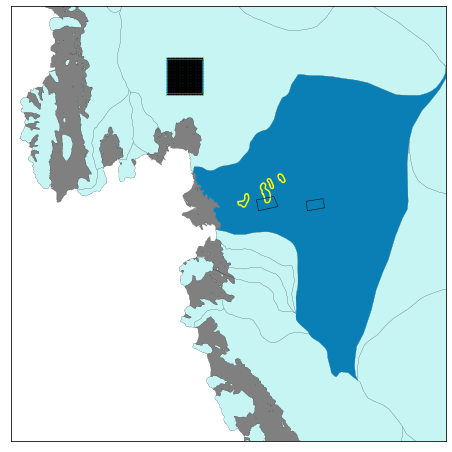

In [30]:
fig, ax = plt.subplots(1,1, figsize = (8,8))
coastlineM.plot(ax=ax, facecolor='grey')
groundinglineM.plot(ax=ax, facecolor='#c6f5f3')
glacierlinesM.plot(ax=ax, facecolor='none',edgecolor='k', linewidth=0.1)
Thwaites.plot(ax=ax, facecolor='#097fb5',edgecolor='none', linewidth=0.1)
plt.plot(*(x0,y0), color = '#ffff00')
plt.plot(*(x1,y1), color = '#ffff00')
plt.plot(*(x2,y2), color = '#ffff00')
plt.plot(*(x3,y3), color = '#ffff00')
plt.scatter(centrex_adj, centrey_adj, s = 0.2, color = 'k')
plt.plot(*poly.exterior.xy, color='k', linewidth = 0.5)
plt.plot(*poly2.exterior.xy, color='k', linewidth = 0.5)
plt.plot(*area_calc.exterior.xy, color='C9', linewidth = 0.5)
plt.plot(*area_data.exterior.xy, color='C9', linewidth = 0.5)
plt.xlim(-2e6, -1e6)
plt.ylim(-1e6,0)
#plt.xlim(-1.3e6, -1.1e6)
#plt.ylim(-0.5e6,-0.3e6)
ax.get_xaxis().set_ticks([]); ax.get_yaxis().set_ticks([]);
plt.savefig('Areacovered.jpg', bbox_inches = 'tight', dpi = 200, facecolor = 'none')

In [31]:
# Make sure it's calculated correctly
print('centre_include:', np.round(np.abs(40/((centrex_adj[0,0]-centrex_adj[0,1])*3/1000))))
print('n:', n)
print('adj:', np.shape(centrex_adj)[0]+1-n)

centre_include: 8.0
n: 3
adj: 48


In [32]:
bounds = np.zeros([len(centrex_adj[0]), len(centrex_adj[1]), 4])

In [33]:
for i,j in itertools.product(range(len(centrex_adj[0])), range(len(centrex_adj[1]))):
    bounds[i,j,:] = centrex_adj[i,j] - (square_size/2), centrex_adj[i,j] + (square_size/2), \
                    centrey_adj[i,j] - (square_size/2), centrey_adj[i,j] + (square_size/2)   

In [34]:
X2 = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
Y2 = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
VX = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
VY = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
SURF = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
BED = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
THICK = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
B_ift = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
C_ift = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)   

In [35]:
%%time
printcounter = 1
for i,j in itertools.product(range(len(centrex_adj[0])), range(len(centrex_adj[1]))):           
        X2[i,j], Y2[i,j], VX[i,j], VY[i,j], SURF[i,j], BED[i,j], THICK[i,j] = \
        data_load(bounds[i,j])
        B_ift[i,j], C_ift[i,j] = \
            bed_conditions2(X2[i,j], Y2[i,j], SURF[i,j], VX[i,j], VY[i,j], THICK[i,j])
        if (printcounter == adj[0]):
            print('Progress report...', (i+1)*(adj[0]+n-1), 'out of', (adj[0]+n-1)*(adj[1]+n-1), \
               'Memory usage', memory_profiler.memory_usage()[0], 'Mb')
            printcounter = 0
        printcounter = printcounter + 1

C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:64: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:48: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:58: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:4: Run

Progress report... 50 out of 2500 Memory usage 839.7421875 Mb
Progress report... 100 out of 2500 Memory usage 1482.15234375 Mb
Progress report... 150 out of 2500 Memory usage 2125.73046875 Mb
Progress report... 200 out of 2500 Memory usage 2771.1328125 Mb
Progress report... 250 out of 2500 Memory usage 3415.78125 Mb
Progress report... 300 out of 2500 Memory usage 4063.875 Mb
Progress report... 350 out of 2500 Memory usage 4705.2109375 Mb
Progress report... 400 out of 2500 Memory usage 5347.546875 Mb
Progress report... 450 out of 2500 Memory usage 5987.95703125 Mb
Progress report... 500 out of 2500 Memory usage 6611.56640625 Mb
Progress report... 550 out of 2500 Memory usage 7250.14453125 Mb
Progress report... 600 out of 2500 Memory usage 7890.49609375 Mb
Progress report... 650 out of 2500 Memory usage 8529.5625 Mb
Progress report... 700 out of 2500 Memory usage 9167.78125 Mb
Progress report... 750 out of 2500 Memory usage 9808.53125 Mb
Progress report... 800 out of 2500 Memory usage 10

In [36]:
def finalise(X2, Y2, B_ift, C_ift):
    trim_bounds = np.zeros([len(centrex_adj[0]), len(centrex_adj[1]), 4])
    extra  = overlap/2 * ((centre_include-1)/centre_include)
    max_X = np.max((X2[0,0].max(), X2[X2.shape[0]-1, X2.shape[0]-1].max()))
    min_X = np.min((X2[0,0].min(), X2[X2.shape[0]-1, X2.shape[0]-1].min()))
    max_Y = np.max((Y2[0,0].max(), Y2[Y2.shape[0]-1, Y2.shape[0]-1].max()))
    min_Y = np.min((Y2[0,0].min(), Y2[Y2.shape[0]-1, Y2.shape[0]-1].min()))
    overall_X = np.arange(min_X, max_X+1, 120)
    overall_Y = np.arange(max_Y, min_Y-1, -120)
    big_X, big_Y = np.meshgrid(overall_X, overall_Y)
    big_bed = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
    big_slip = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
    big_bedmach = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
    
    big_bed2 = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
    big_slip2 = np.zeros((len(centrex_adj[0]), len(centrex_adj[1])), dtype=np.ndarray)
    big_bed2_total = np.zeros(big_X.shape)
    big_slip2_total = np.zeros(big_X.shape)
    for i,j in itertools.product(range(len(centrex_adj[0])), range(len(centrex_adj[1]))):
        trim_bounds[i,j,:] = centrex_adj[i,j] - (overlap/2)+extra, centrex_adj[i,j] + (overlap/2)-extra, \
                    centrey_adj[i,j] - (overlap/2)+extra, centrey_adj[i,j] + (overlap/2)-extra
        B_ift[i,j][X2[i,j]<trim_bounds[i,j][0]] = 0
        B_ift[i,j][X2[i,j]>trim_bounds[i,j][1]] = 0
        B_ift[i,j][Y2[i,j]<trim_bounds[i,j][2]] = 0
        B_ift[i,j][Y2[i,j]>trim_bounds[i,j][3]] = 0
        C_ift[i,j][X2[i,j]<trim_bounds[i,j][0]] = 0
        C_ift[i,j][X2[i,j]>trim_bounds[i,j][1]] = 0
        C_ift[i,j][Y2[i,j]<trim_bounds[i,j][2]] = 0
        C_ift[i,j][Y2[i,j]>trim_bounds[i,j][3]] = 0
        BED[i,j][X2[i,j]<trim_bounds[i,j][0]] = 0
        BED[i,j][X2[i,j]>trim_bounds[i,j][1]] = 0
        BED[i,j][Y2[i,j]<trim_bounds[i,j][2]] = 0
        BED[i,j][Y2[i,j]>trim_bounds[i,j][3]] = 0
        length = X2[i,j].shape
        xl = next(x for x, val in enumerate(overall_X)\
                       if val >= (X2[i,j][0,0])) 
        xh = next(x for x, val in enumerate(overall_X)\
                       if val >= (X2[i,j][length[0]-1, length[1]-1]))
        yl = next(x for x, val in enumerate(overall_Y)\
                       if val <= (Y2[i,j][0,0])) 
        yh = next(x for x, val in enumerate(overall_Y)\
                        if val <= (Y2[i,j][length[0]-1, length[1]-1]))
        big_bed[i,j] = np.zeros(big_X.shape)
        big_bed[i,j][yl:yh+1, xl:xh+1] = B_ift[i,j] 
        big_slip[i,j] = np.zeros(big_X.shape)
        big_slip[i,j][yl:yh+1, xl:xh+1] = C_ift[i,j] 
        big_bedmach[i,j] = np.zeros(big_X.shape)
        big_bedmach[i,j][yl:yh+1, xl:xh+1] = BED[i,j] 
    big_bed_total = np.sum(big_bed)/(n**2)
    big_slip_total = np.sum(big_slip)/(n**2)
    big_bedmach_total = np.sum(big_bedmach)/(n**2)
    for i,j in itertools.product(range(len(centrex_adj[0])), range(len(centrex_adj[1]))):
        B_ift[i,j][X2[i,j]<trim_bounds[i,j][0]] = np.nan
        B_ift[i,j][X2[i,j]>trim_bounds[i,j][1]] = np.nan
        B_ift[i,j][Y2[i,j]<trim_bounds[i,j][2]] = np.nan
        B_ift[i,j][Y2[i,j]>trim_bounds[i,j][3]] = np.nan
        length = X2[i,j].shape
        xl = next(x for x, val in enumerate(overall_X)\
                       if val >= (X2[i,j][0,0])) 
        xh = next(x for x, val in enumerate(overall_X)\
                       if val >= (X2[i,j][length[0]-1, length[1]-1]))
        yl = next(x for x, val in enumerate(overall_Y)\
                       if val <= (Y2[i,j][0,0])) 
        yh = next(x for x, val in enumerate(overall_Y)\
                        if val <= (Y2[i,j][length[0]-1, length[1]-1]))
        big_bed2[i,j] = np.zeros((big_X.shape)) * np.nan
        big_bed2[i,j][yl:yh+1, xl:xh+1] = B_ift[i,j]
        big_slip2[i,j] = np.zeros((big_X.shape)) * np.nan
        big_slip2[i,j][yl:yh+1, xl:xh+1] = C_ift[i,j]
        big_bed2[i,j] =np.abs((big_bed[i,j] - big_bed_total)**2)
        big_bed2[i,j][big_bed[i,j] == 0] = 0
        big_slip2[i,j] =np.abs((big_slip[i,j] - big_slip_total)**2)
        big_slip2[i,j][big_bed[i,j] == 0] = 0
        big_slip2_total = big_bed2_total + (big_bed2[i,j]/(n**2))
    big_bed2_total = np.sum(big_bed2)/(n**2)
    big_bed2_total = np.sqrt(big_bed2_total)
    big_slip2_total = np.sum(big_slip2)/(n**2)
    big_slip2_total = np.sqrt(big_slip2_total)
    # Calculate which parts of the grid to include
    width_x = overlap * adj[0] / (n * centre_include)
    width_y = overlap * adj[1] / (n * centre_include)
    outer_X_min = centre_coord[0] - width_x/2
    outer_X_max = centre_coord[0] + width_x/2
    outer_Y_min = centre_coord[1] - width_y/2
    outer_Y_max = centre_coord[1] + width_y/2
    xl = next(x for x, val in enumerate(overall_X)\
                       if val >= outer_X_min) 
    xh = next(x for x, val in enumerate(overall_X)\
                       if val >= outer_X_max)
    yl = next(x for x, val in enumerate(overall_Y)\
                       if val <= outer_Y_max) 
    yh = next(x for x, val in enumerate(overall_Y)\
                        if val <= outer_Y_min)
    overall_X2 = big_X[yl:yh, xl:xh]
    overall_Y2 = big_Y[yl:yh, xl:xh]
    overall_bed = big_bed_total[yl:yh,xl:xh]
    overall_bedmach = big_bedmach_total[yl:yh,xl:xh]
    overall_slip = big_slip_total[yl:yh,xl:xh]
    overall_b_std = big_bed2_total[yl:yh,xl:xh]
    overall_c_std = big_slip2_total[yl:yh,xl:xh]
    return overall_X2, overall_Y2, overall_bed, overall_bedmach, \
                overall_slip, overall_b_std, overall_c_std 

In [38]:
overall_X2, overall_Y2, overall_bed, overall_bedmach, \
                overall_slip, overall_b_std, overall_c_std  = finalise(X2, Y2, B_ift, C_ift)

C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:44: ComplexWarning: Casting complex values to real discards the imaginary part
C:\Users\s1502187\Anaconda3\envs\geo_py37\lib\site-packages\ipykernel_launcher.py:46: ComplexWarning: Casting complex values to real discards the imaginary part


MemoryError: Unable to allocate 9.18 MiB for an array with shape (1097, 1097) and data type float64

In [ ]:
filename = 'output_2003.nc'
Write_to_nc(overall_X2, overall_Y2, overall_bedmach, overall_bed, overall_b_std, \
            overall_slip, overall_c_std, filename)

In [ ]:
fig, ax = plt.subplots(2,3,figsize = (20,10))
im = [[[],[],[]],[[],[],[]]]
cb = [[[],[],[]],[[],[],[]]]
d = 1
im[0][0] = ax[0,0].pcolor(overall_X2[::d,::d], overall_Y2[::d,::d],overall_bedmach[::d,::d])
im[0][1] = ax[0,1].pcolor(overall_X2[::d,::d], overall_Y2[::d,::d],overall_bed[::d,::d])
im[1][0] = ax[1,0].pcolor(overall_X2[::d,::d], overall_Y2[::d,::d],overall_b_std[::d,::d], cmap = 'coolwarm')
im[1][0].set_clim(0,100)
im[0][2] = ax[0,2].pcolor(overall_X2[::d,::d], overall_Y2[::d,::d],overall_b_std[::d,::d], cmap = 'coolwarm')
im[0][2].set_clim(0,100)
im[1][1] = ax[1,1].pcolor(overall_X2[::d,::d], overall_Y2[::d,::d],overall_slip[::d,::d], cmap = 'coolwarm')
im[1][1].set_clim(0,200)
im[1][2] = ax[1][2].pcolor(overall_X2[::d,::d], overall_Y2[::d,::d],overall_c_std[::d,::d], cmap = 'coolwarm')
im[1][2].set_clim(0,50)
for i,j in itertools.product(range(2), range(3)):
    cb[i][j] = plt.colorbar(im[i][j], ax = ax[i,j])
    ax[i,j].get_xaxis().set_ticks([]); ax[i,j].get_yaxis().set_ticks([]);
ax[1,0].set_visible(False)
cb[1][0].remove()
im[0][1].set_clim(np.min(overall_bedmach), np.max(overall_bedmach))

In [ ]:
big_X = None
big_Y = None
big_bed_total = None
big_bed2_total = None
big_bedmach_total = None
big_slip_total = None
big_slip2_total = None
overall_X = None
overall_Y = None

In [22]:
## To calculate bed conditions with the slope not aligned north/south
def bed_conditions2(X2, Y2, SURF, VX, VY, THICK):
    ## To calculate the slope ##
    # Flatten data for matrices
    xs = np.ndarray.flatten(X2[::,::])
    ys = np.ndarray.flatten(Y2[::,::])
    zs = np.ndarray.flatten(SURF[::, ::])
    # do fit
    tmp_A = []
    tmp_b = []
    for i in range(len(xs)):
        tmp_A.append([xs[i], ys[i], 1])
        tmp_b.append(zs[i])
    b = np.matrix(tmp_b).T
    A = np.matrix(tmp_A)
    # Manual solution
    fit = (A.T * A).I * A.T * b
    alpha_s = np.array((fit[0]**2 + fit[1] **2)/ (np.sqrt((fit[0]**2 + fit[1] **2))))
    angle = (np.arctan2(fit[1],fit[0]) *180/np.pi)#+90
    #Calculate the slope array
    Z2 = X2 * np.array(fit[0]) + Y2 * np.array(fit[1]) + np.array(fit[2])
    spacing = X2[0,1]-X2[0,0]
    h_bar = np.mean(THICK)
    Ice_speed = np.sqrt(VX**2 + VY**2)
    mean_ice_vel = np.mean((Ice_speed))
    u_bar = mean_ice_vel #* 10/
    Flow_direction = np.arctan2(VY,VX) * 180/np.pi
    Angle_to_slope = angle - Flow_direction
    VX_prime = Ice_speed * np.cos(Angle_to_slope * np.pi/180)
    VY_prime = -Ice_speed * np.sin(Angle_to_slope * np.pi/180)
    # To smooth the edges down
    edge_smoothing = ((np.nanmax(Y2) - np.nanmin(Y2)) * tapering)
    edge_w = int(edge_smoothing/spacing)
    tap1 = np.linspace(0,1,edge_w)
    tap2x = np.ones(SURF.shape[1]- 2* edge_w)
    tap2y = np.ones(SURF.shape[0]- 2* edge_w)
    tap3 = np.flip(tap1)
    tapx = np.hstack([tap1,tap2x,tap3])
    tapy = np.hstack([tap1,tap2y,tap3])
    X1, Y1 = np.meshgrid(tapx,tapy)
    z = X1*Y1
    # Subtract mean and smooth
    S_corr = SURF - Z2
    S_corr = S_corr - np.mean(S_corr)
    U_corr = VY_prime - np.mean(VY_prime)
    V_corr = VX_prime - np.mean(VX_prime)
    # Non dimensionalise and smooth edges with z
    S_4inv = S_corr / h_bar * z
    S_4inv = S_4inv - np.mean(S_4inv)
    U_4inv = U_corr / u_bar * z
    U_4inv = U_4inv - np.mean(U_4inv)
    V_4inv = V_corr / u_bar * z
    V_4inv = V_4inv - np.mean(V_4inv)
    # Fourier transform
    S_ft = fft2(S_4inv)
    U_ft = fft2(U_4inv)
    V_ft = fft2(V_4inv)
    # Create the arrays of k and l for the tranfer functions 
    ar1 = np.fft.fftfreq(SURF.shape[1], spacing/h_bar)
    ar2 = np.fft.fftfreq(SURF.shape[0], spacing/h_bar)
    k,l = np.meshgrid(ar1,ar2)
    j = np.sqrt( k **2 + l **2)
    theta = np.arctan2(l,k) * (180/np.pi)
    # Recalculate the transfer functions in the right direction
    wave_angle_to_slope = theta - np.array(angle) 
    k_prime = j * np.cos(wave_angle_to_slope * np.pi/180)
    l_prime = j * np.sin(wave_angle_to_slope * np.pi/180)
    # Smoothing the input data and weighting it appropriately
    S_filt_ft_b, S_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, S_ft)
    U_filt_ft_b, U_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, U_ft)
    V_filt_ft_b, V_filta_b = filter(p_b, erB, k_prime, l_prime, alpha_s, V_ft)
    S_filt_ft_c, S_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, S_ft)
    U_filt_ft_c, U_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, U_ft)
    V_filt_ft_c, V_filta_c = filter(p_c, erC, k_prime, l_prime, alpha_s, V_ft)
    # Calculating the inverse transfer functions
    TBS, TBU, TBV = calcLM_KK(erB, k_prime, l_prime, alpha_s, rLM_KK = False, BtrueCfalse = True)
    TCS, TCU, TCV = calcLM_KK(erC, k_prime, l_prime, alpha_s, rLM_KK = False, BtrueCfalse = False)
    # Calculating the bed conditions, inverse fourier transform and rescaling
    B_ft = TBV * V_filt_ft_b + TBU * U_filt_ft_b + TBS * S_filt_ft_b
    C_ft = TCV * V_filt_ft_c + TCU * U_filt_ft_c + TCS * S_filt_ft_c
    B_ft[np.isnan(B_ft)] = 0
    C_ft[np.isnan(C_ft)] = 0
    cutoff_angle = 15
    wav_ang2 = np.arctan2(k_prime, l_prime) * 180/np.pi
    wav_ang2[np.abs(wav_ang2) < cutoff_angle] = 0
    wav_ang2[np.abs(wav_ang2) > 180-cutoff_angle] = 0
    wav_ang2[np.abs(wav_ang2) != 0] = 1
    B_ift = (ifft2(B_ft*wav_ang2) * h_bar) + Z2 - (h_bar)
    C_ift = ifft2(C_ft*wav_ang2) * C + C
    return B_ift, C_ift